# Task 3

## Configuration

In [3]:
class Config:
    seed : int = 42              # the seed for determing results of random
    # data
    data_root: str = "./data"    # where CIFAR10 will download
    batch_size: int = 256        # CIFAR10 is small, so bigger batch ok
    num_workers: int = 2
    num_classes: int = 10        # CIFAR10 = 10 classes

    # training
    epochs: int = 8
    lr: float = 3e-4             # AdamW works fine
    weight_decay: float = 1e-4
    amp: bool = True             # mixed precision

    # image sizes
    img_size: int = 32           # CIFAR10 native resolution
    resnet_in_size: int = 224    # ResNet expects 224x224 (will upscale CIFAR10)
    clip_in_size: int = 224      # CLIP ViT-B/32 expects 224x224

    # models
    resnet_model: str = "resnet50"
    clip_model: str = "ViT-B/32"

    # training strategy
    freeze_backbone_epochs: int = 2
    # finetune_resnet: bool = True     # train ResNet50
    # use_pretrained_clip: bool = True # CLIP stays frozen

config = Config()


## Imports

In [4]:
!pip install git+https://github.com/openai/CLIP.git #Installing clip library

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-czzefgxw
  Running command git clone --filter=blob:none --quiet https://github.com/openai/CLIP.git /tmp/pip-req-build-czzefgxw
  Resolved https://github.com/openai/CLIP.git to commit dcba3cb2e2827b402d2701e7e1c7d9fed8a20ef1
  Preparing metadata (setup.py) ... done


In [5]:
import clip
from PIL import Image, ImageFilter, ImageOps
import numpy as np      # is ke ialwa ghar nahi chale ga
import matplotlib.pyplot as plt
import cv2
import math    # small math helpers (ceil waghra)
import random           # reproducible shuffling
import copy          # deepcopy models for best chjkpnts
import os
import time
import requests
from io import BytesIO

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim     # optimizers
from torch.utils.data import DataLoader, ConcatDataset     # batched loading
from torchvision import datasets, transforms, models  #datasets + aug
from torchvision.transforms import functional as TF   # low level transforms
from sklearn.decomposition import PCA

SEED = config.seed
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.deterministic = True   # deterministic convs(slower)
torch.backends.cudnn.benchmark = False      # disable autotuner for determinnsm

## Base Dataset (CIFAR-10)

In [6]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip32, clipPreprocess = clip.load(config.clip_model, device=device)

imagenet_mean = [0.485, 0.456, 0.406] # because we are finetuning, not training from scratch
imagenet_std  = [0.229, 0.224, 0.225]

cifar10_classes = [
    "airplane",
    "automobile",
    "bird",
    "cat",
    "deer",
    "dog",
    "frog",
    "horse",
    "ship",
    "truck",
]

# resnet transforms, we use preprocess for clip
resnet_train_transform = transforms.Compose([
    transforms.Resize(config.resnet_in_size),   # upscale from 32→224
    transforms.RandomHorizontalFlip(),          # simple aug
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

resnet_test_transform = transforms.Compose([
    transforms.Resize(config.resnet_in_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std),
])

# datasets
resnet_train_dataset = datasets.CIFAR10(
    root=config.data_root,
    train=True,
    download=True,
    transform=resnet_train_transform
)

resnet_test_dataset = datasets.CIFAR10(
    root=config.data_root,
    train=False,
    download=True,
    transform=resnet_test_transform
)

clip_test_dataset = datasets.CIFAR10(
    root=config.data_root,
    train=False,
    download=True,
    transform=clipPreprocess
)

img_resnet, label1 = resnet_test_dataset[0]
img_clip, label2 = clip_test_dataset[0]
assert label1 == label2

# dataloaders
resnet_train_loader = DataLoader(
    resnet_train_dataset,
    batch_size=config.batch_size,
    shuffle=True,
    num_workers=config.num_workers,
    pin_memory=True
)

resnet_test_loader = DataLoader(
    resnet_test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

clip_test_loader = DataLoader(
    clip_test_dataset,
    batch_size=config.batch_size,
    shuffle=False,
    num_workers=config.num_workers,
    pin_memory=True
)

print(f"Train batches: {len(resnet_train_loader)}, Test batches: {len(resnet_test_loader)}")


Train batches: 196, Test batches: 40


## Models

In [7]:
device = "cuda" if torch.cuda.is_available() else "cpu"
clip32, clipPreprocess = clip.load(config.clip_model, device=device)

def build_resnet50(num_classes=config.num_classes):
    # torchvision resnet50 with ImageNet weights
    m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2)
    in_features = m.fc.in_features  # final feature dim
    m.fc = nn.Linear(in_features, num_classes)  # replace classifier
    return m

def count_params(m):
    return sum( p.numel() for p in m.parameters())/1e6

resnet = build_resnet50().to(device) # make model ?
print(f"CLIP ViT-B/32 parameters: { count_params(clip32):.1f}M")
print(f"Resnet-50 parameters: {count_params(resnet):.1f}M")

CLIP ViT-B/32 parameters: 151.3M
Resnet-50 parameters: 23.5M


In [8]:
@torch.no_grad()
def evaluate_resnet(model, loader, classnames):
    model.eval()
    total = 0
    correct = 0
    class_correct = [0 for _ in classnames]
    class_total = [0 for _ in classnames]

    for imgs, labels in loader:
        imgs, labels = imgs.to(device), labels.to(device)
        logits = model(imgs)
        preds = logits.argmax(dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # per-class stats
        for l, p in zip(labels, preds):
            class_total[l] += 1
            if l == p:
                class_correct[l] += 1

    overall_acc = correct / total
    per_class_acc = [c/t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    return overall_acc, per_class_acc


@torch.no_grad()
def evaluate_clip(model, preprocess, loader, classnames, template="a photo of a {}"):
    model.eval()
    total, correct = 0, 0
    class_correct = [0 for _ in classnames]
    class_total = [0 for _ in classnames]

    # make text features once
    texts = [template.format(c) for c in classnames]
    text_tokens = clip.tokenize(texts).to(device)
    text_features = model.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    for imgs, labels in loader:
        # preprocess each image in the batch for CLIP
        # imgs = torch.stack([preprocess(transforms.ToPILImage()(img)) for img in imgs])
        imgs = imgs.to(device)
        labels = labels.to(device)

        # image features
        image_features = model.encode_image(imgs)
        image_features /= image_features.norm(dim=-1, keepdim=True)

        # similarity scores [batch, num_classes]
        logits = image_features @ text_features.T
        preds = logits.argmax(dim=1)

        total += labels.size(0)
        correct += (preds == labels).sum().item()

        # per-class stats
        for l, p in zip(labels, preds):
            class_total[l] += 1
            if l == p:
                class_correct[l] += 1

    overall_acc = correct / total
    per_class_acc = [c/t if t > 0 else 0.0 for c, t in zip(class_correct, class_total)]
    return overall_acc, per_class_acc


### Fine-tuning Resnet

In [9]:
def set_backbone_requires_grad(model , requires_grad: bool , head_names = ("fc", "head")):  # full conv
    """freeze ya  tou unfreeze everything except classifier head/heads"""
    for n, p in model.named_parameters():
        #heuristics: allow final 'fc' (resnet) or head (ViT) to train
        if any (n.startswith(h) for h in head_names):
            p.requires_grad = True
        else:
            p.requires_grad = requires_grad

def train_one_epoch(model,loader, optimizer,scaler, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    start = time.time()
    for i, (imgs, labels) in enumerate(loader):
        imgs , labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad(set_to_none=True)

        #amp forward or backward for speed on colab ka gpu
        with torch.cuda.amp.autocast(enabled=config.amp):
            logits = model(imgs)
            loss = F.cross_entropy(logits, labels)

        #keep track of acc
        preds = logits.argmax(dim=1)
        total = total + labels.size(0)
        correct= correct+ (preds == labels).sum(). item( )
        running_loss = running_loss+ loss.item() * labels.size(0)

        #amp backw
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        #light progress each approx 2000 images
        if ( i+1) % max(1 , (2000 // config.batch_size)) == 0:
            bsz_done = (i+1)*config.batch_size  # batch size done
            acc_now = correct / total
            print(f"[epoch {epoch+1}/{total_epochs}] seen={bsz_done:5d} loss={loss.item():.3f} acc~{acc_now:.3f}")

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / total
    dt = time.time() - start
    return epoch_loss, epoch_acc, dt

def fit_classifier(model, name: str, train_loader, test_loader, head_names = ("fc","head")):
    # warmup-- train only the last layers
    set_backbone_requires_grad(model, requires_grad=False, head_names=head_names)
    optimizer = optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=config.lr, weight_decay=config.weight_decay
    )
    scaler = torch.cuda.amp.GradScaler(enabled=config.amp)

    best_acc = 0.0
    best_wts = copy.deepcopy(model.state_dict())

    # tracking history
    train_losses, train_accs, test_accs = [], [], []

    for epoch in range(config.epochs):
        # unfreeze backbone after warmup
        if epoch == config.freeze_backbone_epochs:
            set_backbone_requires_grad(model, requires_grad=True, head_names=head_names)
            optimizer = optim.AdamW(
                model.parameters(), lr=config.lr, weight_decay=config.weight_decay
            )

        loss, train_acc, dt = train_one_epoch(model, train_loader, optimizer, scaler, epoch, config.epochs)
        test_acc, _ = evaluate_resnet(model, test_loader, cifar10_classes)

        # log history
        train_losses.append(loss)
        train_accs.append(train_acc)
        test_accs.append(test_acc)

        print(f"[{name}] epoch {epoch+1}/{config.epochs} | train_loss={loss:.3f} "
              f"train_acc={train_acc:.3f} test_acc={test_acc:.3f} ({dt:.1f}s)")

        # keep best weights
        if test_acc > best_acc:
            best_acc = test_acc
            best_wts = copy.deepcopy(model.state_dict())

    # restore best
    model.load_state_dict(best_wts)
    print(f"[{name}] best test acc: {best_acc:.3f}")

    # plot curves
    epochs_range = range(1, config.epochs + 1)

    plt.figure(figsize=(12,4))

    # training loss
    plt.subplot(1,2,1)
    plt.plot(epochs_range, train_losses, marker='o')
    plt.title(f"{name} Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    # accuracy curves
    plt.subplot(1,2,2)
    plt.plot(epochs_range, train_accs, label="Train", marker='o')
    plt.plot(epochs_range, test_accs, label="Test", marker='o')
    plt.title(f"{name} Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.show()

    return model, best_acc

In [10]:
# train resnet 50:
# Comment this out after trained once to save time

# resnet, resnet_best = fit_classifier(resnet, "ResNet50", resnet_train_loader, resnet_test_loader, head_names=("fc",))
# torch.save(resnet.state_dict(), "resnet50_cifar10_best.pth")

In [11]:
resnet = build_resnet50().to(device)
resnet.load_state_dict(torch.load("resnet50_cifar10_best.pth", map_location=device))
resnet.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

##Zero-Shot Classification (CIFAR-10)
CLIP that has never seen CIFAR-10 in training, vs Resnet trained on CIFAR-10

In [11]:
# evaluate resnet
resnet_acc, resnet_per_class = evaluate_resnet(resnet, resnet_test_loader, cifar10_classes)

# evaluate clip
clip_acc, clip_per_class = evaluate_clip(
    clip32, clipPreprocess, clip_test_loader, cifar10_classes, template="a photo of a {}"
)

# print results
print("\n=== Overall Accuracy ===")
print(f"ResNet50 (finetuned on CIFAR-10): {resnet_acc:.3f}")
print(f"CLIP ViT-B/32 (zero-shot):       {clip_acc:.3f}")

print("\n=== Per-Class Accuracy ===")
for i, cname in enumerate(cifar10_classes):
    print(f"{cname:10s} | ResNet50: {resnet_per_class[i]:.3f} | CLIP: {clip_per_class[i]:.3f}")



=== Overall Accuracy ===
ResNet50 (finetuned on CIFAR-10): 0.957
CLIP ViT-B/32 (zero-shot):       0.888

=== Per-Class Accuracy ===
airplane   | ResNet50: 0.947 | CLIP: 0.900
automobile | ResNet50: 0.983 | CLIP: 0.976
bird       | ResNet50: 0.944 | CLIP: 0.889
cat        | ResNet50: 0.925 | CLIP: 0.860
deer       | ResNet50: 0.962 | CLIP: 0.765
dog        | ResNet50: 0.934 | CLIP: 0.883
frog       | ResNet50: 0.984 | CLIP: 0.773
horse      | ResNet50: 0.944 | CLIP: 0.976
ship       | ResNet50: 0.985 | CLIP: 0.955
truck      | ResNet50: 0.962 | CLIP: 0.899


## Domain Generalization (PACS Dataset)

In [12]:
# Run this command if havent unzipped PACS, make sure to upload the PACS zip to colab
# !unzip PACS.zip -d pacs_data

Archive:  PACS.zip
replace pacs_data/kfold/art_painting/dog/pic_001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [13]:
# define transforms
pacs_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],
                         std=[0.5, 0.5, 0.5])
])

# load a specific domain
def get_pacs_domain(root, domain, transform, batch_size=32, shuffle=True):
    domain_path = os.path.join(root, domain)
    dataset = datasets.ImageFolder(domain_path, transform=transform)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle)
    return dataset, loader

root = "/content/pacs_data/kfold"

In [14]:
domains = ["art_painting", "cartoon", "photo", "sketch"]
prompts = ["a painting of a {}", "a cartoon image of a {}", "a photo of a {}", "a sketch of a {}"]
pacs_classes = ["dog", "elephant", "giraffe", "guitar", "horse", "house", "person"]

resnet_loaders, clip_loaders = {}, {}

for d in domains:
    _, resnet_loaders[d] = get_pacs_domain(root, d, resnet_test_transform, batch_size=64)
    _, clip_loaders[d]   = get_pacs_domain(root, d, clipPreprocess, batch_size=64)

# build new ResNet
resnet_pacs = build_resnet50(len(pacs_classes)).to(device)

###Fine-tuning Resnet

In [15]:
# combine datasets/loaders for source domains
source_domains = ["art_painting", "cartoon", "photo"]
source_loaders = [resnet_loaders[d] for d in source_domains]
source_datasets = [d.dataset for d in source_loaders]  # extract underlying datasets
combined_dataset = ConcatDataset(source_datasets)
combined_loader = DataLoader(combined_dataset, batch_size=64, shuffle=True)

In [16]:
# # Comment this out after trained once to save time
# # fine-tune on combined source domains
# resnet_pacs, best_acc = fit_classifier(
#     resnet_pacs,
#     "ResNet50-PACS",
#     combined_loader,
#     resnet_loaders["sketch"],  # test on sketch domain for simplicity
#     head_names=("fc",)
# )

# # save model
# torch.save(resnet_pacs.state_dict(), "resnet50_pacs_best.pth")

In [17]:
resnet_pacs = build_resnet50(len(pacs_classes)).to(device)
resnet_pacs.load_state_dict(torch.load("resnet50_pacs_best.pth", map_location=device))
resnet_pacs.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

###Evaluating Zero-shot CLIP vs Fine-tuned Resnet

In [19]:
# evaluate ResNet
resnet_acc, resnet_per_class = evaluate_resnet(
    resnet_pacs,
    resnet_loaders["sketch"],
    pacs_classes
)

# evaluate CLIP
clip_acc, clip_per_class = evaluate_clip(
    clip32,
    clipPreprocess,
    clip_loaders["sketch"],
    pacs_classes,
    template="a sketch of a {}"
)

# print overall accuracies
print(f"ResNet50-PACS overall accuracy on Sketch: {resnet_acc:.3f}")
print(f"CLIP zero-shot overall accuracy on Sketch: {clip_acc:.3f}")

# per-class accuracies
for c, r_acc, cl_acc in zip(pacs_classes, resnet_per_class, clip_per_class):
    print(f"{c:10s} | ResNet: {r_acc:.3f} | CLIP: {cl_acc:.3f}")

ResNet50-PACS overall accuracy on Sketch: 0.722
CLIP zero-shot overall accuracy on Sketch: 0.851
dog        | ResNet: 0.526 | CLIP: 0.724
elephant   | ResNet: 0.796 | CLIP: 0.905
giraffe    | ResNet: 0.440 | CLIP: 0.644
guitar     | ResNet: 0.985 | CLIP: 0.992
horse      | ResNet: 0.846 | CLIP: 0.985
house      | ResNet: 0.925 | CLIP: 1.000
person     | ResNet: 0.919 | CLIP: 0.900


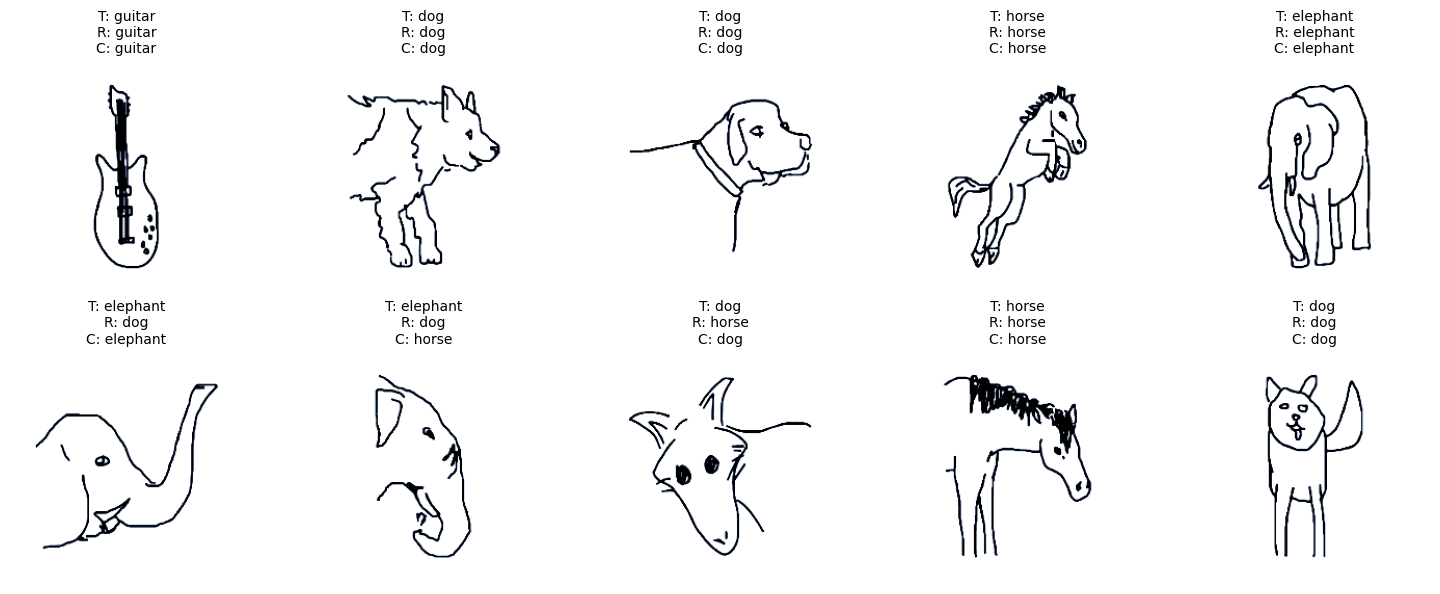

In [20]:
# pick 10 random indices
dataset = resnet_loaders["sketch"].dataset
clip_dataset = clip_loaders["sketch"].dataset
indices = random.sample(range(len(dataset)), 10)

plt.figure(figsize=(15,6))

for i, idx in enumerate(indices):
    img_resnet, label = dataset[idx]   # ResNet-normalized tensor
    clip_img, _ = clip_dataset[idx]    # already preprocessed for CLIP

    # ResNet prediction
    resnet_pacs.eval()
    with torch.no_grad():
        inp = img_resnet.unsqueeze(0).to(device)
        logits = resnet_pacs(inp)
        resnet_pred = logits.argmax(dim=1).item()

    # CLIP prediction
    clip32.eval()
    with torch.no_grad():
        clip_inp = clip_img.unsqueeze(0).to(device)  # already preprocessed
        image_features = clip32.encode_image(clip_inp)
        image_features /= image_features.norm(dim=-1, keepdim=True)
        # text features
        texts = clip.tokenize([f"a sketch of a {c}" for c in pacs_classes]).to(device)
        text_features = clip32.encode_text(texts)
        text_features /= text_features.norm(dim=-1, keepdim=True)
        logits = image_features @ text_features.T
        clip_pred = logits.argmax(dim=1).item()

    # show original image (undo ResNet normalization for display)
    img_show = img_resnet.permute(1,2,0).cpu().numpy()
    img_show = img_show * 0.5 + 0.5  # undo [-1,1] normalization
    plt.subplot(2,5,i+1)
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(f"T: {pacs_classes[label]}\nR: {pacs_classes[resnet_pred]}\nC: {pacs_classes[clip_pred]}",
              fontsize=10)

plt.tight_layout()
plt.show()


## Image-Text Retrieval

To get a variety of images across different domains and classes, I am using PACS for this experiment as well. I will sample 20 images at random such that each image has a unique combination of class and domain.

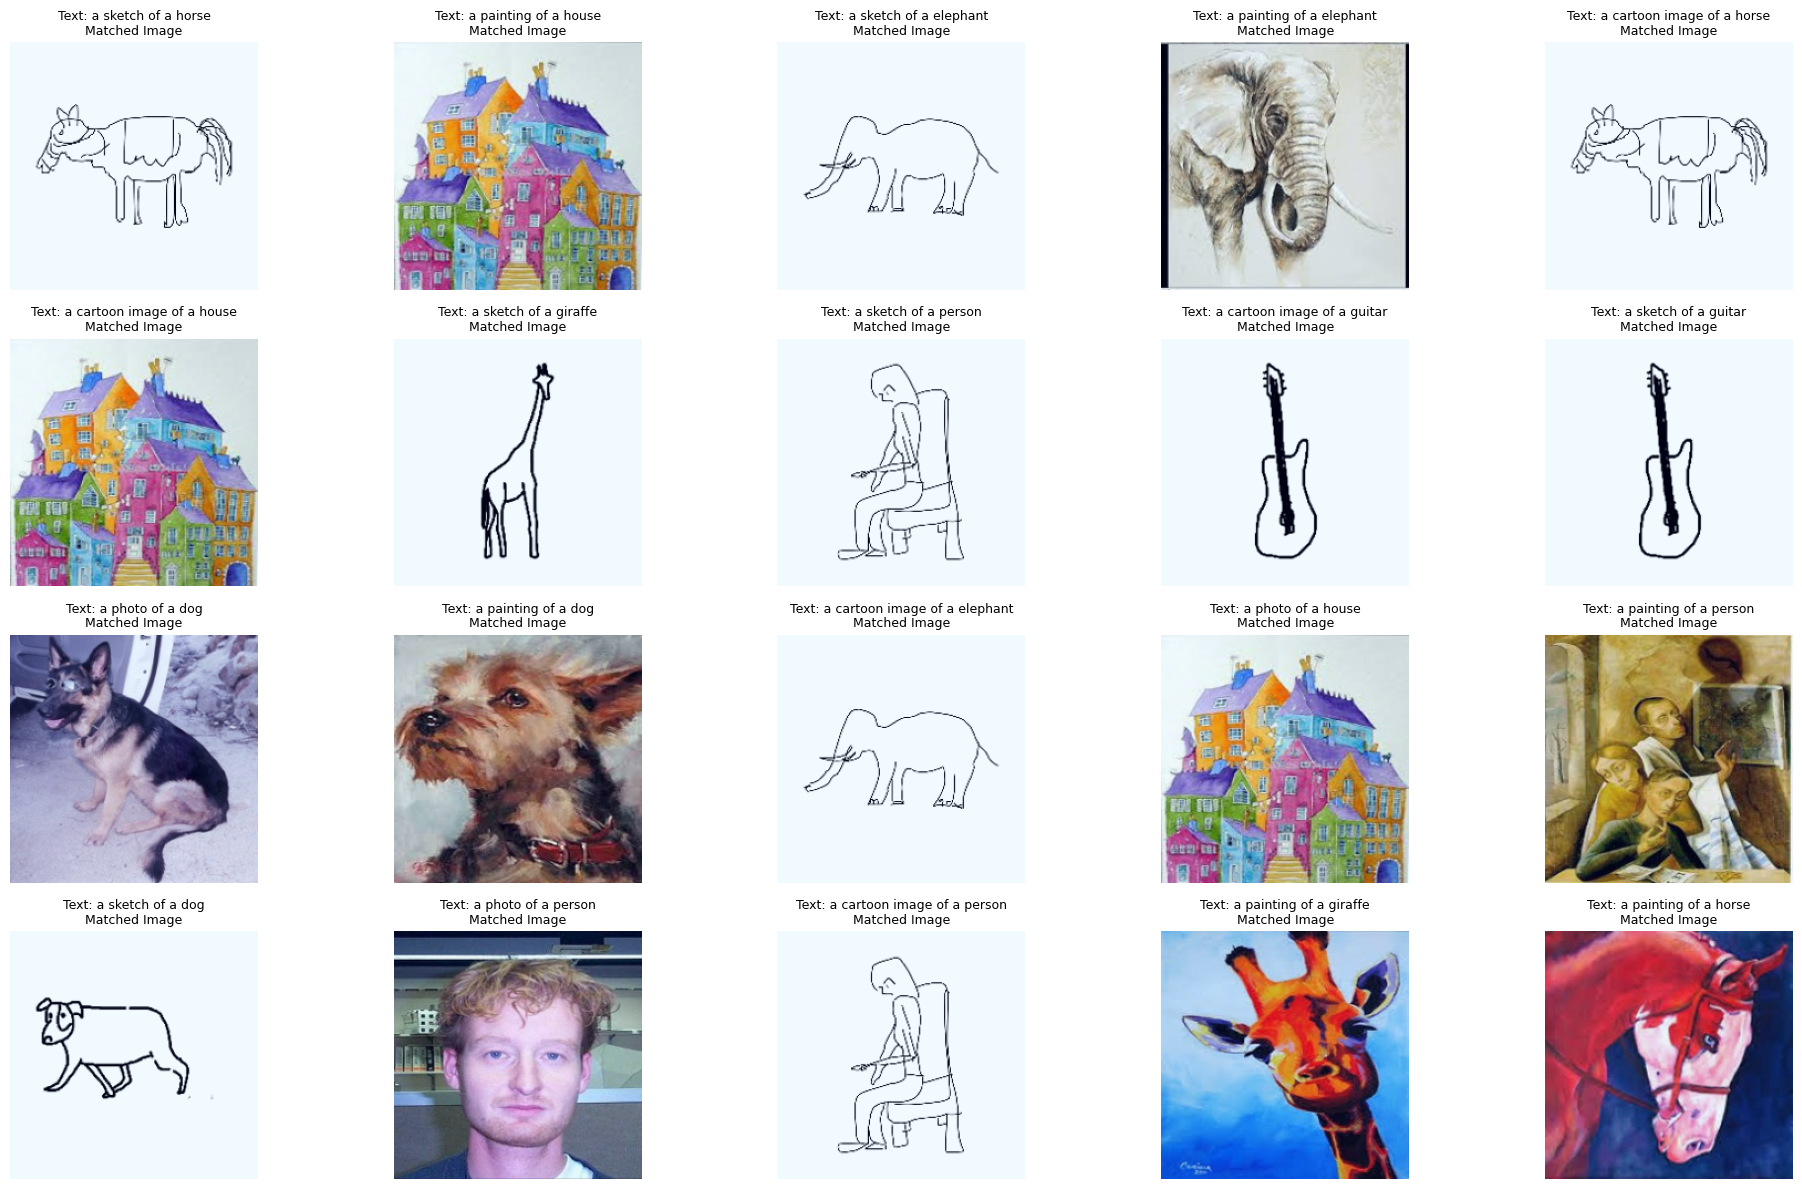

In [21]:
all_clip_dataset = []
all_labels = []
all_domains = []

for d_idx, d in enumerate(domains):
    dataset = clip_loaders[d].dataset  # dataset already preprocessed for CLIP
    for img, label in dataset:
        all_clip_dataset.append(img)
        all_labels.append(label)
        all_domains.append(d_idx)

# sample 20 images with unique (class, domain) combinations
selected_indices = []
used_pairs = set()
while len(selected_indices) < 20:
    idx = random.randint(0, len(all_clip_dataset)-1)
    pair = (all_labels[idx], all_domains[idx])
    if pair not in used_pairs:
        used_pairs.add(pair)
        selected_indices.append(idx)

# prepare image and text embeddings
images = torch.stack([all_clip_dataset[i] for i in selected_indices]).to(device)
text_descriptions = [prompts[all_domains[i]].format(pacs_classes[all_labels[i]])
                     for i in selected_indices]

text_tokens = clip.tokenize(text_descriptions).to(device)

with torch.no_grad():
    image_features = clip32.encode_image(images)
    image_features /= image_features.norm(dim=-1, keepdim=True)

    text_features = clip32.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

    # similarity [num_texts, num_images]
    sims = text_features @ image_features.T
    top_matches = sims.argmax(dim=1)  # top image per text

# visualize 4x5 grid
plt.figure(figsize=(20, 12))
for i, idx in enumerate(selected_indices):
    img = images[top_matches[i]].cpu()
    # convert to PIL-like for display
    img_show = img.permute(1,2,0).numpy()
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())  # normalize for display

    plt.subplot(4,5,i+1)
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(f"Text: {text_descriptions[i]}\nMatched Image", fontsize=9)

plt.tight_layout()
plt.show()

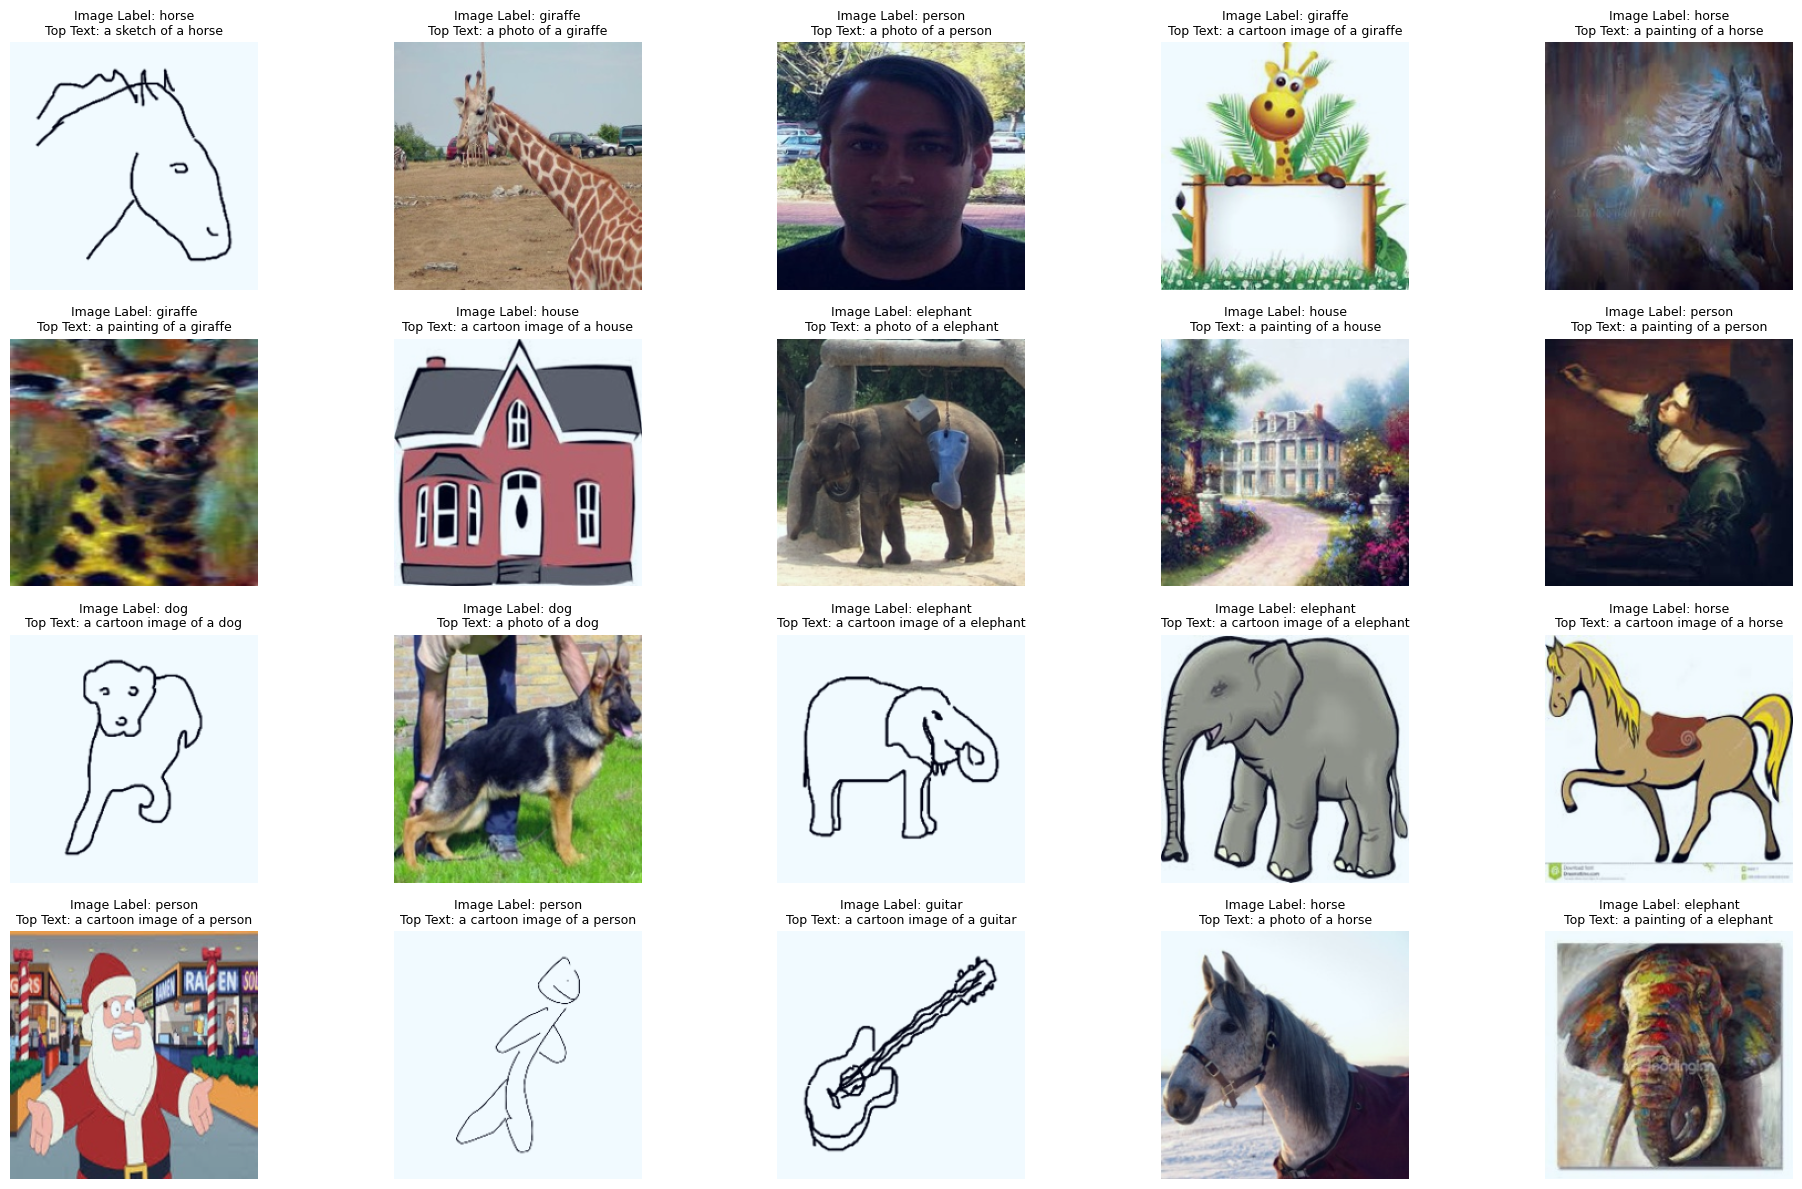

In [22]:
# sample another 20 images with unique (class, domain) combinations
selected_indices_img = []
used_pairs = set()
while len(selected_indices_img) < 20:
    idx = random.randint(0, len(all_clip_dataset)-1)
    pair = (all_labels[idx], all_domains[idx])
    if pair not in used_pairs:
        used_pairs.add(pair)
        selected_indices_img.append(idx)

# prepare image and text embeddings
images_img = torch.stack([all_clip_dataset[i] for i in selected_indices_img]).to(device)
text_descriptions_all = [prompts[d].format(c) for d in range(len(domains)) for c in pacs_classes]
text_tokens_all = clip.tokenize(text_descriptions_all).to(device)

with torch.no_grad():
    image_features_img = clip32.encode_image(images_img)
    image_features_img /= image_features_img.norm(dim=-1, keepdim=True)

    text_features_all = clip32.encode_text(text_tokens_all)
    text_features_all /= text_features_all.norm(dim=-1, keepdim=True)

    # similarity [num_images, num_texts]
    sims_img = image_features_img @ text_features_all.T
    top_text_per_image = sims_img.argmax(dim=1)

# visualize 4x5 grid
plt.figure(figsize=(20, 12))
for i, idx in enumerate(selected_indices_img):
    img = images_img[i].cpu()
    img_show = img.permute(1,2,0).numpy()
    img_show = (img_show - img_show.min()) / (img_show.max() - img_show.min())  # normalize for display

    top_text = text_descriptions_all[top_text_per_image[i].item()]

    plt.subplot(4,5,i+1)
    plt.imshow(img_show)
    plt.axis("off")
    plt.title(f"Image Label: {pacs_classes[all_labels[idx]]}\nTop Text: {top_text}", fontsize=9)

plt.tight_layout()
plt.show()


##Representation Analysis

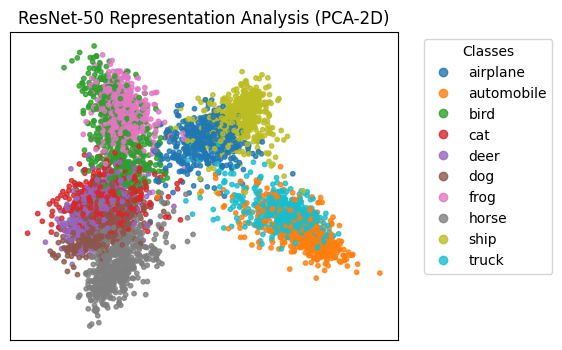

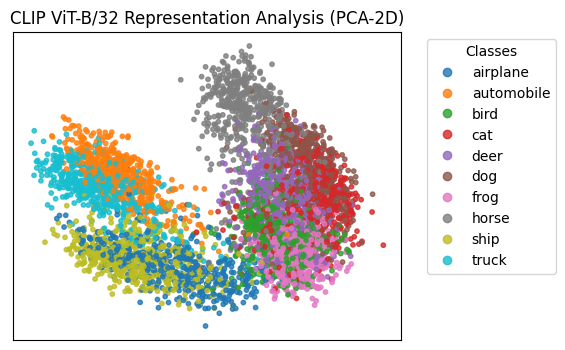

In [24]:

@torch.no_grad()
def extract_resnet_features(model, loader, max_batches=20):
    model.eval()
    feats = []
    labels = []
    hook_out = {}

    def hook_fn(module, input, output):
        hook_out['feat'] = output

    handle = model.avgpool.register_forward_hook(hook_fn)

    for i, (imgs, ys) in enumerate(loader):
        if i >= max_batches: break
        imgs = imgs.to(device)
        _ = model(imgs)
        f = hook_out['feat'].squeeze()  # (N, 2048)
        if f.ndim > 2:  # safety: squeeze down (N, C)
            f = f.mean(dim=(2,3))
        feats.append(f.detach().cpu())
        labels.append(ys)

    handle.remove()

    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()
    return feats, labels

@torch.no_grad()
def extract_clip_features(model, loader, max_batches=20):
    model.eval()
    feats = []
    labels = []
    for i, (imgs, ys) in enumerate(loader):
        if i >= max_batches: break
        imgs = imgs.to(device)
        f = model.encode_image(imgs)  # (N, 512)
        f /= f.norm(dim=-1, keepdim=True)  # optional normalization
        feats.append(f.cpu())
        labels.append(ys)
    feats = torch.cat(feats).numpy()
    labels = torch.cat(labels).numpy()
    return feats, labels

resnet_feats, resnet_lbls = extract_resnet_features(resnet, resnet_test_loader, max_batches=20)
clip32_feats, clip32_lbls = extract_clip_features(clip32, clip_test_loader, max_batches=20)

pca2 = PCA(n_components=2, random_state=SEED)
r2 = pca2.fit_transform(resnet_feats)
c2 = pca2.fit_transform(clip32_feats)

# scatter plots
def scatter_2d(X2, y, title, classnames):
    plt.figure(figsize=(5,4))
    scatter = plt.scatter(X2[:,0], X2[:,1], c=y, s=10, alpha=0.8, cmap="tab10")
    plt.title(title)
    plt.xticks([]); plt.yticks([])

    # add legend with class names
    handles, _ = scatter.legend_elements()
    plt.legend(handles, classnames, title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.show()

scatter_2d(r2, resnet_lbls, "ResNet-50 Representation Analysis (PCA-2D)", cifar10_classes)
scatter_2d(c2, clip32_lbls,    "CLIP ViT-B/32 Representation Analysis (PCA-2D)", cifar10_classes)

##Robustness Testing

In [12]:
def pil_to_cv2(img_pil):
    return cv2.cvtColor(np.array(img_pil), cv2.COLOR_RGB2BGR)

def cv2_to_pil(img_cv2):
    return Image.fromarray(cv2.cvtColor(img_cv2, cv2.COLOR_BGR2RGB))

# 1) Sketch / stylization (best single diagnostic)
def sketch_filter(img_pil):
    """
    Uses OpenCV's pencilSketch if available; fallback to edge + blend if not.
    Returns PIL image.
    """
    try:
        img_cv2 = pil_to_cv2(img_pil)
        # pencilSketch returns (dst_gray, dst_color) -- use color sketch
        dst_gray, dst_color = cv2.pencilSketch(img_cv2, sigma_s=60, sigma_r=0.07, shade_factor=0.05)
        return cv2_to_pil(dst_color)
    except Exception:
        # fallback: Canny edges blended on grayscale
        img_gray = np.array(img_pil.convert("L"))
        edges = cv2.Canny(img_gray, 100, 200)
        edges_rgb = np.stack([edges]*3, axis=-1)
        blended = np.clip(np.array(img_pil) * 0.6 + (255-edges_rgb) * 0.4, 0, 255).astype(np.uint8)
        return Image.fromarray(blended)

# 2) Gaussian noise
def gaussian_noise_filter(img_pil, sigma=25):
    arr = np.array(img_pil).astype(np.float32)
    noise = np.random.normal(0, sigma, arr.shape).astype(np.float32)
    noised = np.clip(arr + noise, 0, 255).astype(np.uint8)
    return Image.fromarray(noised)

# 3) Motion blur (kernel along a random direction)
def motion_blur_filter(img_pil, ksize=15, angle=0):
    img_cv2 = pil_to_cv2(img_pil)
    # create motion blur kernel
    kernel = np.zeros((ksize, ksize))
    kernel[ksize//2, :] = np.ones(ksize)
    # rotate kernel by angle
    M = cv2.getRotationMatrix2D((ksize/2-0.5, ksize/2-0.5), angle, 1)
    kernel = cv2.warpAffine(kernel, M, (ksize, ksize))
    kernel = kernel / kernel.sum()
    blurred = cv2.filter2D(img_cv2, -1, kernel)
    return cv2_to_pil(blurred)

# 4) JPEG compression / pixelation
def jpeg_compression_filter(img_pil, quality=15):
    # save to buffer with low quality and reload
    import io
    buf = io.BytesIO()
    img_pil.save(buf, format="JPEG", quality=quality)
    buf.seek(0)
    return Image.open(buf).convert("RGB")

# helper that returns a dict of filtered PIL images
def make_filters(img_pil):
    # choose random motion blur angle for variety
    angle = np.random.uniform(-45, 45)
    return {
        "original": img_pil,
        "sketch": sketch_filter(img_pil),
        "gaussian_noise": gaussian_noise_filter(img_pil, sigma=25),
        "motion_blur": motion_blur_filter(img_pil, ksize=15, angle=angle),
        "jpeg": jpeg_compression_filter(img_pil, quality=15),
    }

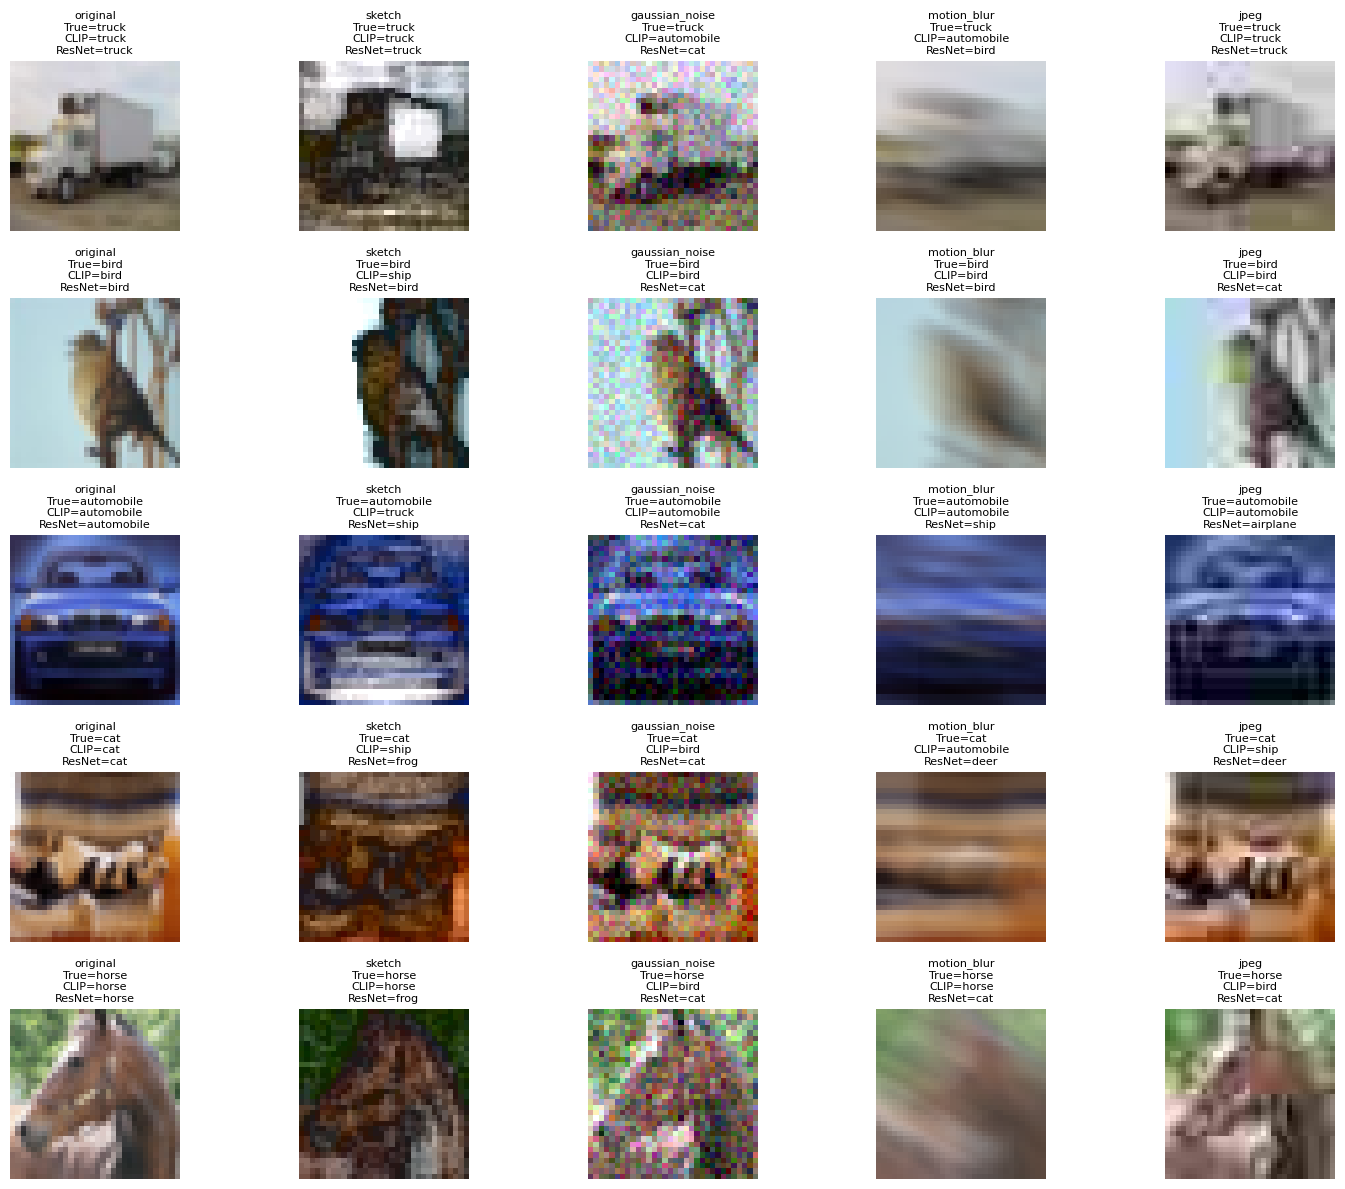

In [13]:
# --- pick 5 random indices from CIFAR-10 test ---
indices = random.sample(range(len(clip_test_dataset)), 5)

# function to predict with CLIP given a PIL image
@torch.no_grad()
def predict_clip(img_pil):
    inp = clipPreprocess(img_pil).unsqueeze(0).to(device)
    feat = clip32.encode_image(inp)
    feat /= feat.norm(dim=-1, keepdim=True)
    # compare with text features
    text_tokens = clip.tokenize(cifar10_classes).to(device)
    text_feats = clip32.encode_text(text_tokens)
    text_feats /= text_feats.norm(dim=-1, keepdim=True)
    sims = (100.0 * feat @ text_feats.T).softmax(dim=-1)
    pred_idx = sims.argmax(dim=-1).item()
    return cifar10_classes[pred_idx]

# function to predict with ResNet given a PIL image
@torch.no_grad()
def predict_resnet(img_pil):
    inp = resnet_test_transform(img_pil).unsqueeze(0).to(device)
    logits = resnet(inp)
    pred_idx = logits.argmax(1).item()
    return cifar10_classes[pred_idx]

# make grid
fig, axes = plt.subplots(len(indices), 5, figsize=(15, 12))

for row, idx in enumerate(indices):
    # get raw PIL + label (no transform)
    raw_pil, label = datasets.CIFAR10(
        root=config.data_root, train=False, download=False, transform=None
    )[idx]

    # apply filters
    filt_dict = make_filters(raw_pil)  # returns dict with original+4 filtered

    # loop through filters in fixed order
    for col, (name, filt_img) in enumerate(filt_dict.items()):
        true_label = cifar10_classes[label]
        clip_pred = predict_clip(filt_img)
        resnet_pred = predict_resnet(filt_img)

        axes[row, col].imshow(filt_img)
        axes[row, col].axis("off")
        axes[row, col].set_title(
            f"{name}\nTrue={true_label}\nCLIP={clip_pred}\nResNet={resnet_pred}",
            fontsize=8
        )

plt.tight_layout()
plt.show()

##Style Transfer (Bias Test)

In [26]:
def to_uint8(img_tensor):
    x = img_tensor.clone().cpu().numpy().transpose(1,2,0)
    x = (x * np.array(imagenet_std) + np.array(imagenet_mean)).clip(0,1)
    return (x*255).astype(np.uint8)

def from_uint8(arr):
    x = arr.astype(np.float32)/255.0
    x = (x - np.array(imagenet_mean)) / np.array(imagenet_std)
    return torch.tensor(x.transpose(2,0,1))

def fft_amplitude_phase(img):  # img: HxWxC uint8 (0..255)
    f = np.fft.fft2(img.astype(np.float32), axes=(0,1))
    amp, phase = np.abs(f), np.angle(f)
    return amp, phase

def fft_reconstruct(amp, phase):
    f = amp * np.exp(1j * phase)
    img = np.fft.ifft2(f, axes=(0,1)).real
    img = np.clip(img, 0, 255).astype(np.uint8)
    return img

def amplitude_swap_conflict(content_uint8, style_uint8, alpha=1.0):
    # alpha=1.0 = full style amplitude; smaller alpha blends some content amplitude
    Ac, Pc = fft_amplitude_phase(content_uint8)
    As, Ps = fft_amplitude_phase(style_uint8)
    A_mix = (1-alpha)*Ac + alpha*As
    conflict = fft_reconstruct(A_mix, Pc)  # phase from content preserves shape
    return conflict

# ---------- style transfer with FFT amplitude swap ----------
def fft_style_transfer(content_img, style_img, alpha=1.0, size=224):
    # resize to match CLIP input
    c = transforms.Resize((size, size))(transforms.ToPILImage()(content_img))
    s = transforms.Resize((size, size))(transforms.ToPILImage()(style_img))
    c, s = transforms.ToTensor()(c), transforms.ToTensor()(s)

    # fft
    c_fft = torch.fft.fft2(c, dim=(-2, -1))
    s_fft = torch.fft.fft2(s, dim=(-2, -1))

    c_amp, c_phase = torch.abs(c_fft), torch.angle(c_fft)
    s_amp = torch.abs(s_fft)

    # mix amplitudes
    amp = (1 - alpha) * c_amp + alpha * s_amp

    # reconstruct
    stylized_fft = amp * torch.exp(1j * c_phase)
    stylized = torch.fft.ifft2(stylized_fft, dim=(-2, -1)).real

    # clip to [0,1]
    stylized = stylized.clamp(0, 1)
    return stylized



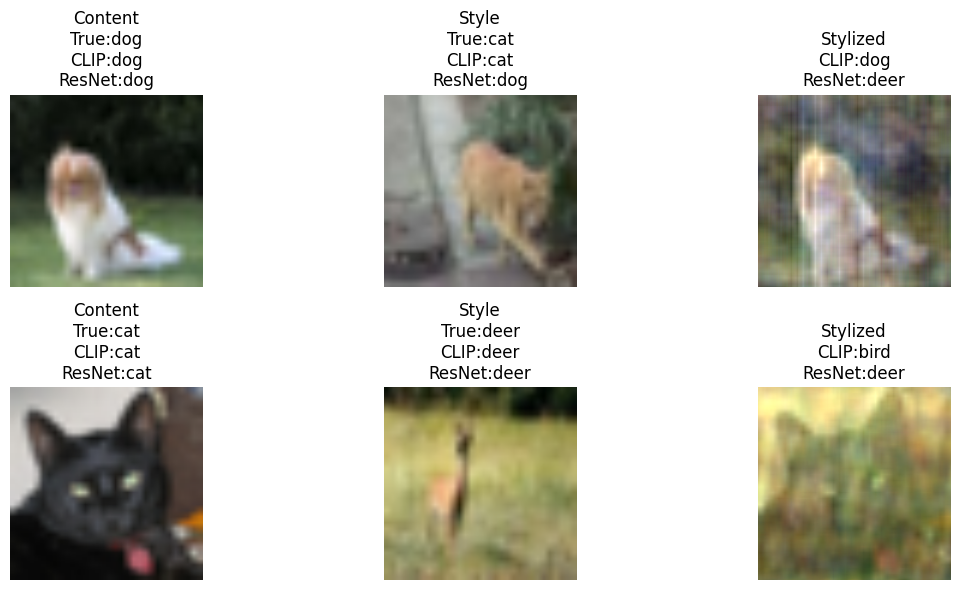

In [54]:
# pick 2 random pairs: content and style (ensuring different class)
def sample_pairs(dataset, n=2):
    pairs = []
    indices = list(range(len(dataset)))
    for _ in range(n):
        while True:
            c_idx, s_idx = random.sample(indices, 2)
            _, c_label = dataset[c_idx]
            _, s_label = dataset[s_idx]
            if c_label != s_label:
                pairs.append((c_idx, s_idx))
                break
    return pairs

@torch.no_grad()
def predict_clip(img_tensor):
    # expects tensor [3,H,W] in [0,1]
    inp = clipPreprocess(transforms.ToPILImage()(img_tensor)).unsqueeze(0).to(device)
    feat = clip32.encode_image(inp)
    feat /= feat.norm(dim=-1, keepdim=True)
    sims = (feat @ text_features.T).squeeze(0)
    return sims.argmax().item()

@torch.no_grad()
def predict_resnet(img_tensor):
    inp = resnet_test_transform(transforms.ToPILImage()(img_tensor)).unsqueeze(0).to(device)
    logits = resnet(inp)
    return logits.argmax(1).item()

def denorm(img_tensor):
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1).to(img_tensor.device)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1).to(img_tensor.device)
    return img_tensor * std + mean

def normalize(img):
    # img: tensor [3,H,W] in [0,1]
    mean = torch.tensor(imagenet_mean).view(3,1,1).to(img.device)
    std  = torch.tensor(imagenet_std).view(3,1,1).to(img.device)
    return (img - mean) / std

def show_grid(pairs):
    fig, axes = plt.subplots(len(pairs), 3, figsize=(12, 6))
    if len(pairs) == 1:
        axes = [axes]  # handle single row

    for row, (c_idx, s_idx) in enumerate(pairs):
        # normalized tensors for prediction
        c_img_norm, c_label = resnet_test_dataset[c_idx]
        s_img_norm, s_label = resnet_test_dataset[s_idx]

        # denormalize for FFT + viz
        c_img = denorm(c_img_norm).clamp(0,1)
        s_img = denorm(s_img_norm).clamp(0,1)

        # style transfer (FFT expects uint8, so convert properly)
        stylized = fft_style_transfer(c_img, s_img, alpha=1.0, size=224)

        # predictions use normalized tensors
        c_clip, s_clip, t_clip = predict_clip(c_img), predict_clip(s_img), predict_clip(stylized)
        c_res, s_res, t_res   = predict_resnet(c_img), predict_resnet(s_img), predict_resnet(stylized)

        # plot
        axes[row][0].imshow(transforms.ToPILImage()(c_img))
        axes[row][0].set_title(
            f"Content\nTrue:{cifar10_classes[c_label]}\nCLIP:{cifar10_classes[c_clip]}\nResNet:{cifar10_classes[c_res]}"
        )
        axes[row][0].axis("off")

        axes[row][1].imshow(transforms.ToPILImage()(s_img))
        axes[row][1].set_title(
            f"Style\nTrue:{cifar10_classes[s_label]}\nCLIP:{cifar10_classes[s_clip]}\nResNet:{cifar10_classes[s_res]}"
        )
        axes[row][1].axis("off")

        axes[row][2].imshow(transforms.ToPILImage()(stylized))
        axes[row][2].set_title(
            f"Stylized\nCLIP:{cifar10_classes[t_clip]}\nResNet:{cifar10_classes[t_res]}"
        )
        axes[row][2].axis("off")

    plt.tight_layout()
    plt.show()

# ---- run the experiment ----
classnames = [
    "airplane", "automobile", "bird", "cat", "deer",
    "dog", "frog", "horse", "ship", "truck"
]  # CIFAR-10; replace with PACS classes if using PACS

template = "a photo of a {}"
prompts = [template.format(c) for c in classnames]

with torch.no_grad():
    text_tokens = clip.tokenize(prompts).to(device)
    text_features = clip32.encode_text(text_tokens)
    text_features /= text_features.norm(dim=-1, keepdim=True)

pairs = sample_pairs(resnet_test_dataset, n=2)
show_grid(pairs)

In [55]:
def evaluate_pairs(dataset, n=100):
    pairs = sample_pairs(dataset, n=n)

    stats = {
        "clip_content_acc": 0,
        "clip_style_acc": 0,
        "clip_stylized_content": 0,
        "clip_stylized_style": 0,
        "res_content_acc": 0,
        "res_style_acc": 0,
        "res_stylized_content": 0,
        "res_stylized_style": 0,
    }

    for c_idx, s_idx in pairs:
        c_img, c_label = dataset[c_idx]
        s_img, s_label = dataset[s_idx]

        c_img = denorm(c_img).clamp(0,1)
        s_img = denorm(s_img).clamp(0,1)

        # style transfer (FFT)
        stylized = fft_style_transfer(c_img, s_img, alpha=1.0, size=224)

        # predictions
        c_clip, s_clip, t_clip = predict_clip(c_img), predict_clip(s_img), predict_clip(stylized)
        c_res, s_res, t_res   = predict_resnet(c_img), predict_resnet(s_img), predict_resnet(stylized)

        # update stats
        stats["clip_content_acc"]        += int(c_clip == c_label)
        stats["clip_style_acc"]          += int(s_clip == s_label)
        stats["clip_stylized_content"]   += int(t_clip == c_label)
        stats["clip_stylized_style"]     += int(t_clip == s_label)

        stats["res_content_acc"]         += int(c_res == c_label)
        stats["res_style_acc"]           += int(s_res == s_label)
        stats["res_stylized_content"]    += int(t_res == c_label)
        stats["res_stylized_style"]      += int(t_res == s_label)

    # normalize
    for k in stats:
        stats[k] /= n

    return stats

# ---- run stats on 100 pairs ----
stats = evaluate_pairs(resnet_test_dataset, n=100)
print("Evaluation over 100 random pairs:")
for k,v in stats.items():
    print(f"{k}: {v:.3f}")


Evaluation over 100 random pairs:
clip_content_acc: 0.810
clip_style_acc: 0.950
clip_stylized_content: 0.200
clip_stylized_style: 0.160
res_content_acc: 0.910
res_style_acc: 0.950
res_stylized_content: 0.220
res_stylized_style: 0.140
